In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import color, exposure, measure, morphology, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

In [9]:
ui = {}
ui['in_dir_path'] = Path(r'../data/CHESS_IA_layer1')
ui['slice_crop'] = None
ui['row_crop'] = [0, 1350]
ui['col_crop'] = [110, 1460]
ui['file_suffix'] = '.tif'
ui['out_dir_path'] = Path(r'../results/CHESS_IA_layer1')
ui['out_prefix'] = 'CHESS_IA_layer1'
ui['save_checkpoint_figs'] = 'show'
ui['nslices'] = 4
ui['rescale_range'] = [0.01, 99.99]
ui['save_semantic'] = True
ui['min_peak_distance'] = 30  # 45 ums @ 1.48 ums/pixel


Loading images...
--> Images loaded as 3D array:  (550, 1350, 1350)
--> Plotting images: [  0 183 366 549]


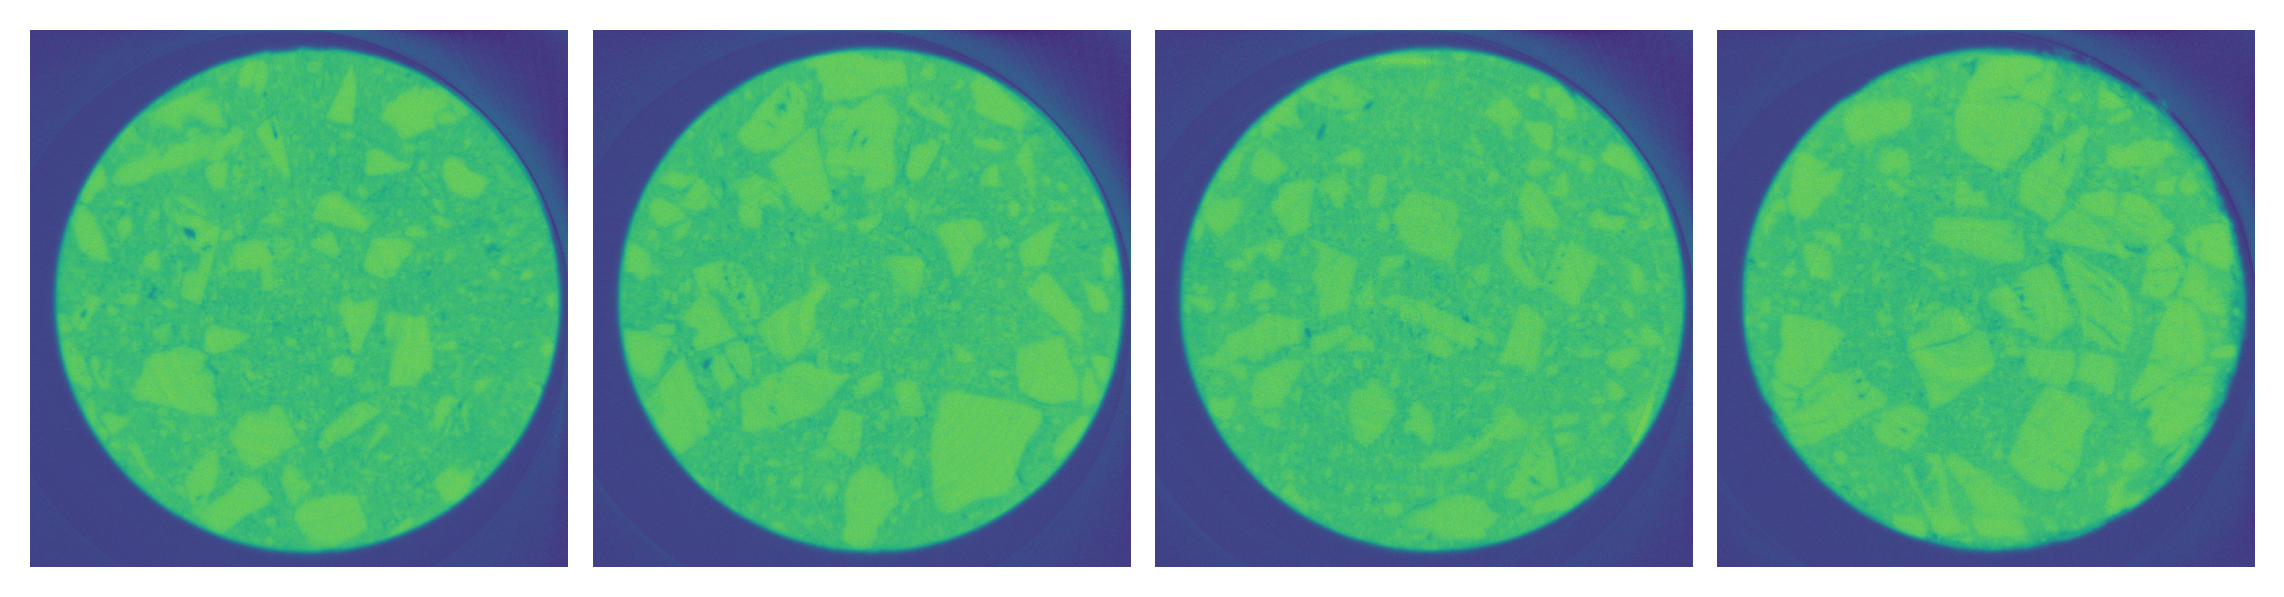

In [3]:
# Number of digits for figure prefix
n_fig_digits = 2
# Initialize at 0 to increase with every saved figure
fig_n = 0
if not Path(ui['out_dir_path']).exists():
    Path(ui['out_dir_path']).mkdir(parents=True)
#-------------#
# Load images #
#-------------#
print()
imgs = segment.load_images(
    ui['in_dir_path'],
    slice_crop=ui['slice_crop'],
    row_crop=ui['row_crop'],
    col_crop=ui['col_crop'],
    convert_to_float=True,
    file_suffix=ui['file_suffix']
)
fig, axes = view.plot_slices(
    imgs,
    nslices=ui['nslices'],
    fig_w=7.5,
    dpi=300
)
if ui['save_checkpoint_figs'] == 'show':
    plt.show()
elif ui['save_checkpoint_figs'] == True:
    plt.savefig(
        Path(ui['out_dir_path'])
        / f'{str(fig_n).zfill(n_fig_digits)}-raw-imgs.png')


Preprocessing images...
--> Applying median filter...
--> Preprocessing complete.


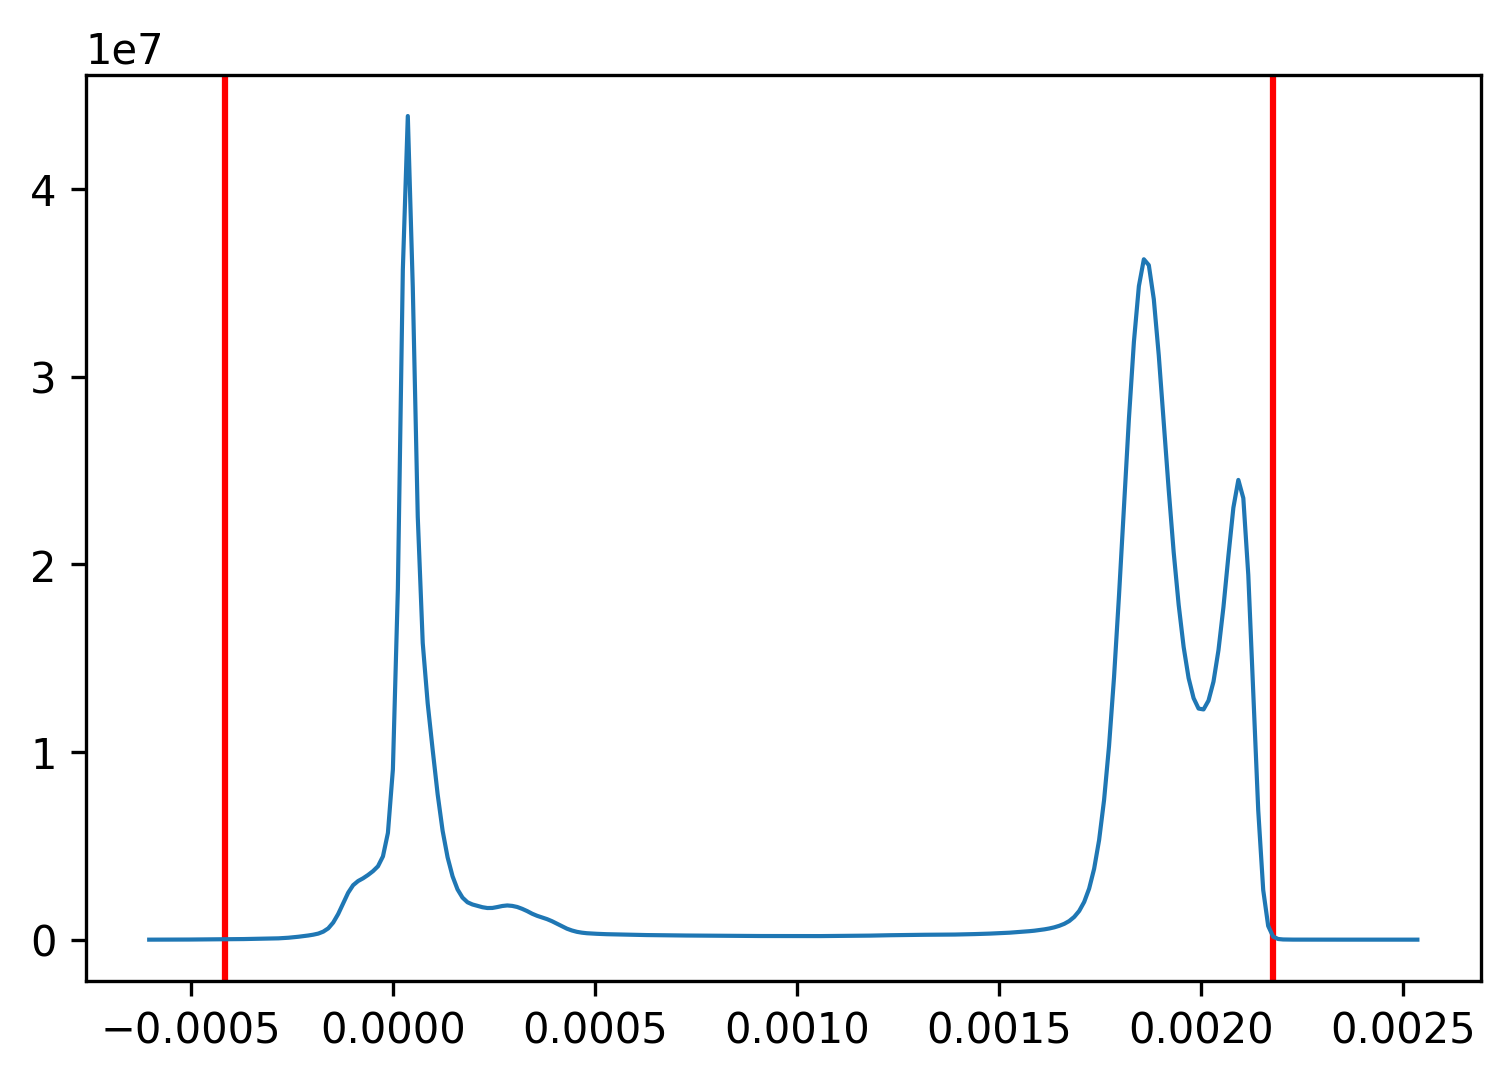

Preprocessing images...
--> Rescaling intensities to percentile range [0.01, 99.99]...
--> Preprocessing complete.
--> Plotting images: [  0 183 366 549]


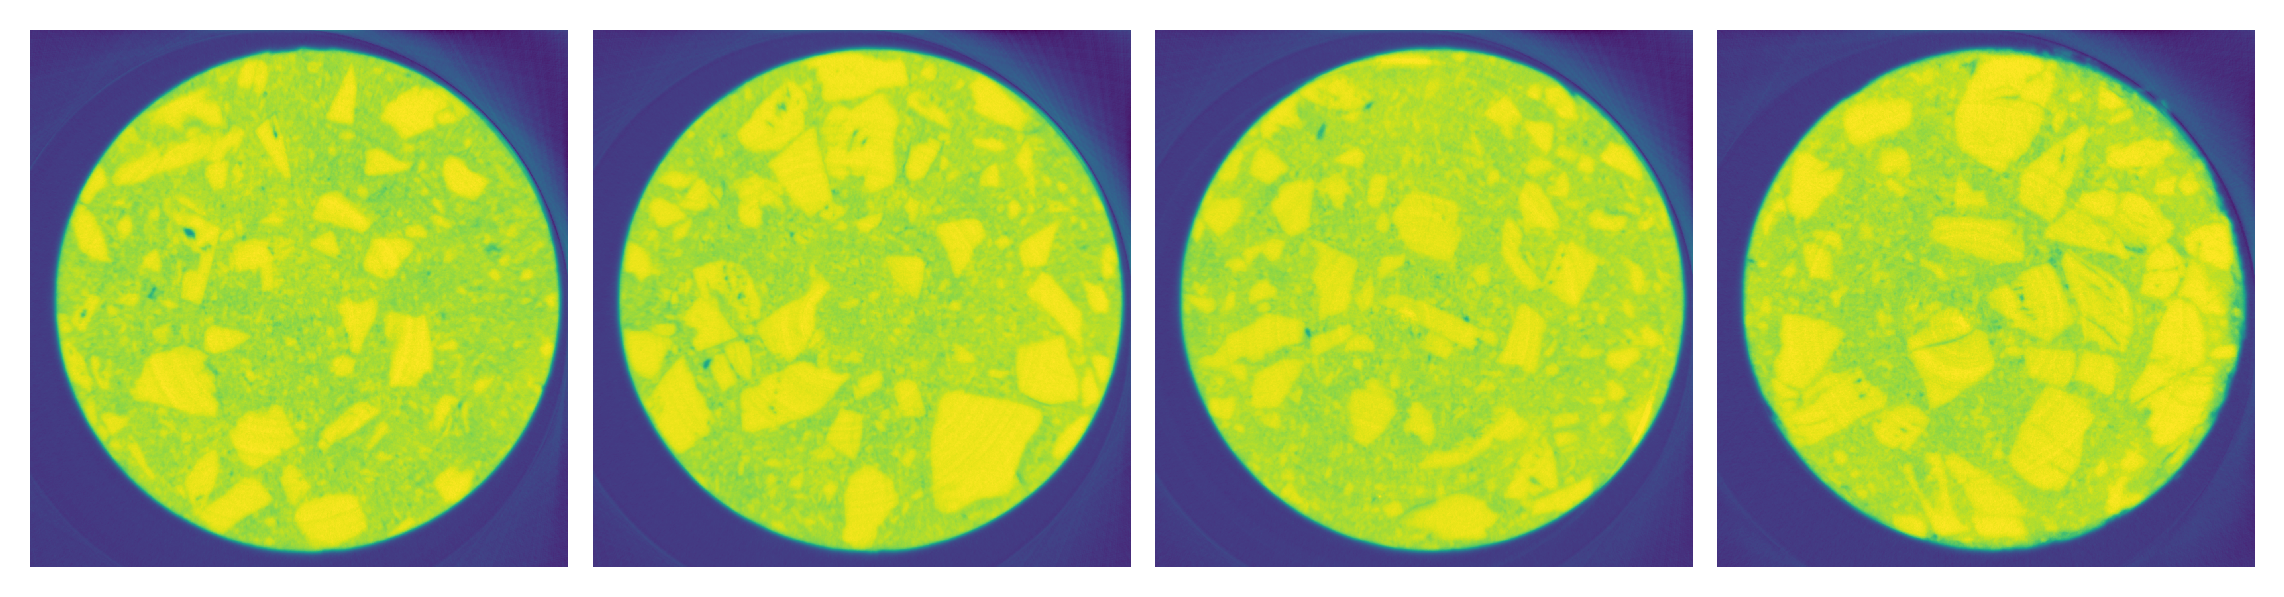

In [4]:
#-------------------#
# Preprocess images #
#-------------------#
print()
# Generate intensity rescale histogram
imgs_med = segment.preprocess(imgs, median_filter=True)
hist, hist_centers = exposure.histogram(imgs_med)
fig, ax = plt.subplots(dpi=300)
ax.plot(hist_centers, hist, lw=1)
for val in ui['rescale_range']:
    p = np.percentile(imgs_med, val)
    ax.axvline(p, c='red', zorder=0)
# Plot intensity rescale histogram
fig_n += 1
if ui['save_checkpoint_figs'] == 'show':
    plt.show()
elif ui['save_checkpoint_figs'] == True:
    plt.savefig(
        Path(ui['out_dir_path'])
        / f'{str(fig_n).zfill(n_fig_digits)}-intensity-rescale-hist.png')
# Preprocess images
imgs_pre = segment.preprocess(
    imgs_med,
    median_filter=False,
    rescale_intensity_range=ui['rescale_range']
)
# Plot preprocessed images
fig, axes = view.slices(
    imgs_pre,
    nslices=ui['nslices'],
    fig_w=7.5,
    dpi=300
)
fig_n += 1
if ui['save_checkpoint_figs'] == 'show':
    plt.show()
elif ui['save_checkpoint_figs'] == True:
    plt.savefig(
        Path(ui['out_dir_path'])
        / f'{str(fig_n).zfill(n_fig_digits)}-preprocessed.png')

Calculating thresholds from local minima...
--> 3 peak(s) found: [11648, 57728, 63104]
--> 2 minima found: [35968, 61056]


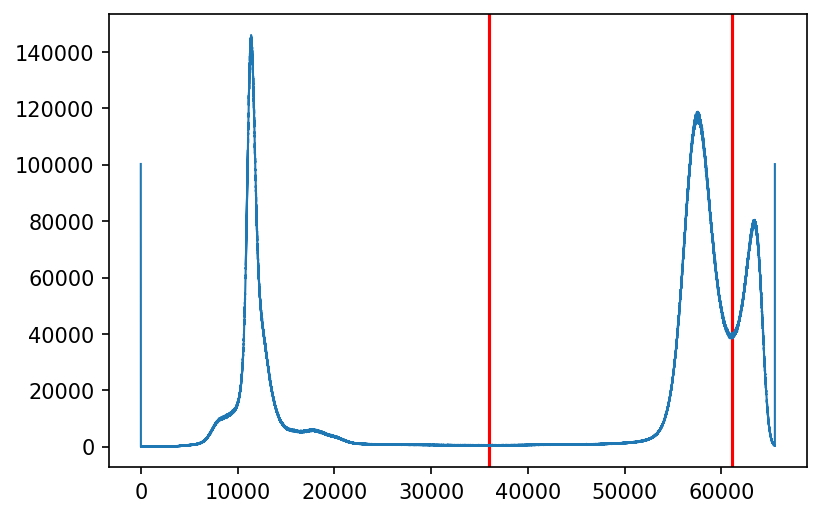

--> Plotting images: [  0 183 366 549]
Calculating voxel statistics...
--> Voxel ratio of particles to binder: 0.42242857913455806


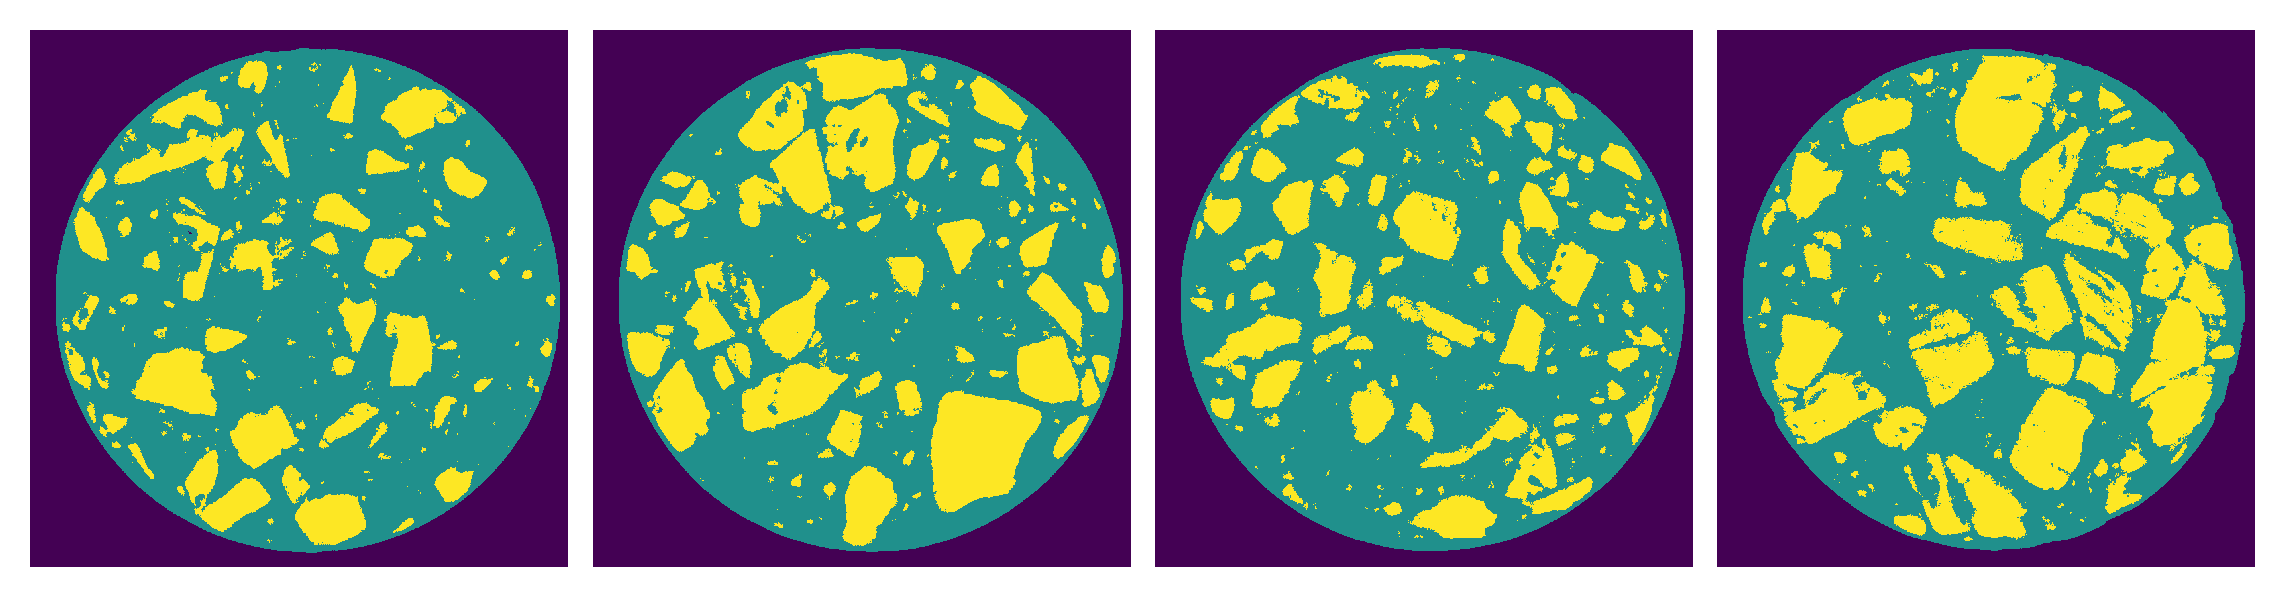

In [5]:
#-----------------------#
# Semantic segmentation #
#-----------------------#
mins = segment.threshold_multi_min(imgs_pre)
imgs_semantic = segment.isolate_classes(imgs_pre, mins)
# Generate semantic seg histogram
hist, hist_centers = exposure.histogram(imgs_pre)
fig, ax = plt.subplots(dpi=150)
ax.plot(hist_centers, hist, lw=1)
for val in mins:
    ax.axvline(val, c='red', zorder=0)
fig_n += 1
# Plot semantic seg histogram
if ui['save_checkpoint_figs'] == 'show':
    plt.show()
elif ui['save_checkpoint_figs'] == True:
    plt.savefig(
        Path(ui['out_dir_path'])
        / f'{str(fig_n).zfill(n_fig_digits)}-semantic-seg-hist.png')
# Plot semantic seg
fig, axes = view.plot_slices(
    imgs_semantic,
    nslices=ui['nslices'],
    fig_w=7.5,
    dpi=300
)
# Calc particle to binder ratio (voxels)
particle_to_binder = segment.calc_voxel_stats(imgs_semantic)
fig_n += 1
if ui['save_checkpoint_figs'] == 'show':
    plt.show()
elif ui['save_checkpoint_figs'] == True:
    plt.savefig(
        Path(ui['out_dir_path'])
        / f'{str(fig_n).zfill(n_fig_digits)}-semantic-seg.png')

In [11]:
print('Mass ratio:')
density_particle = 2.001
density_binder = 1.19
print(0.422 * density_particle / density_binder)

Mass ratio:
0.709598319327731


In [10]:
if ui['save_semantic']:
    semantic_dir_path = (
        Path(ui['out_dir_path']) / f"{ui['out_prefix']}_voxels_semantic")
    segment.save_images(imgs_semantic, semantic_dir_path)

550 image(s) saved to: C:\Users\gusb\Research\mhe-analysis\results\CHESS_IA_layer1\CHESS_IA_layer1_voxels_semantic


uint8
Segmenting images...
--> Segmentation complete. 769 particle(s) segmented.


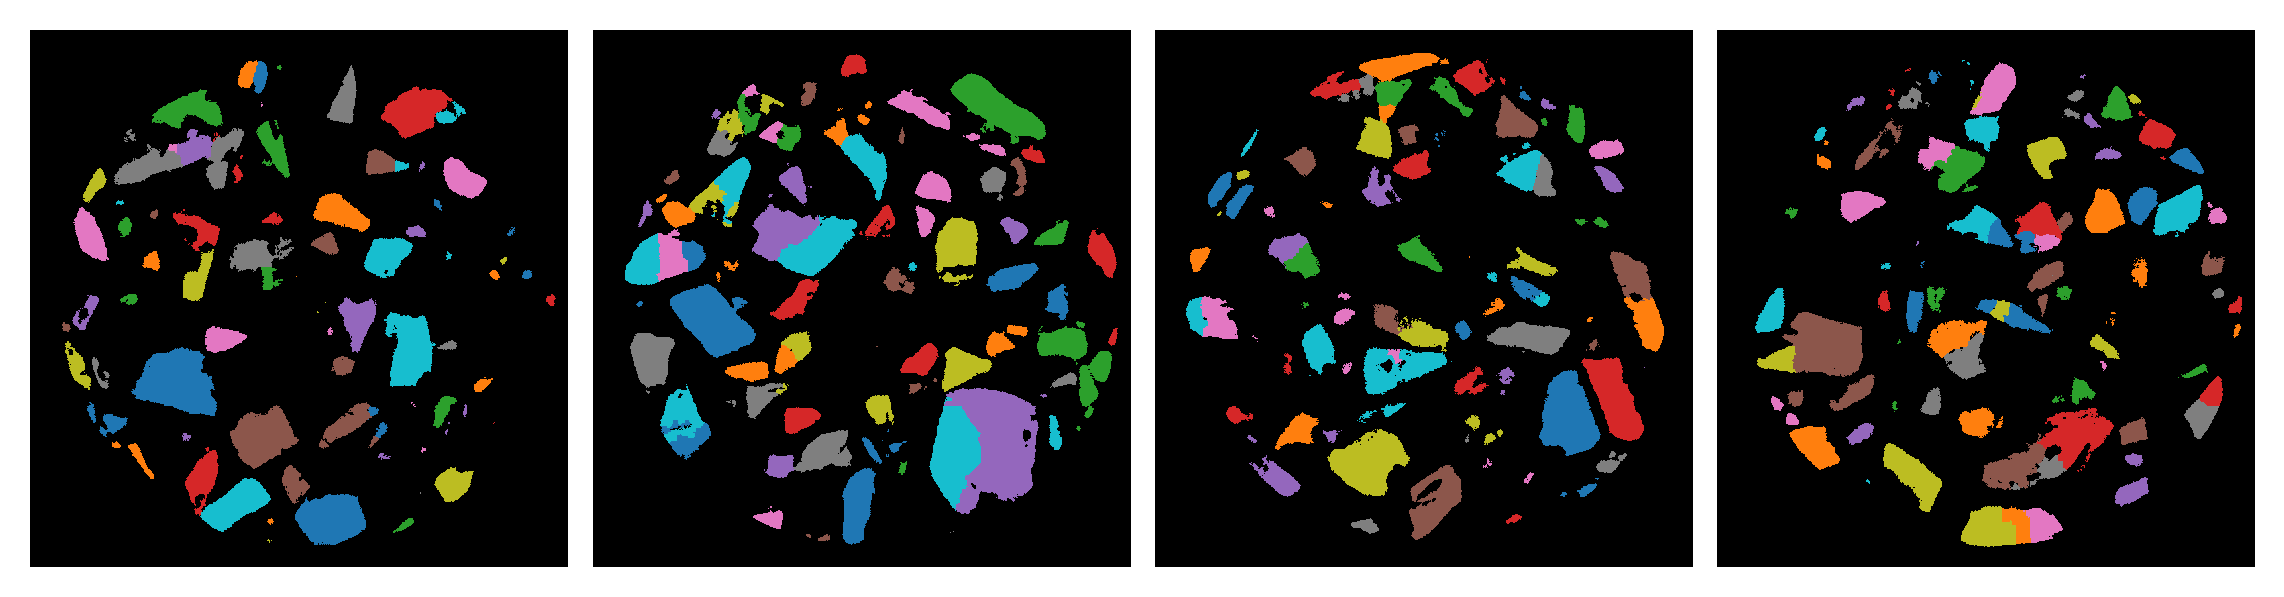

In [7]:
imgs = None
imgs_med = None
imgs_pre = None
imgs_instance = None
# semantic_dir_path = (
#     Path(ui['out_dir_path']) / f"{ui['out_prefix']}_voxels_semantic")
# imgs_semantic = segment.load_images(semantic_dir_path, file_suffix='.tif')
print(imgs_semantic.dtype)
#-----------------------#
# Instance segmentation #
#-----------------------#
imgs_instance = segment.watershed_segment(
    imgs_semantic==2,
    min_peak_distance=ui['min_peak_distance'],
    use_int_dist_map=False,
    exclude_borders=False,
    return_dict=False
)
# Visualize instance segmented grains with binder
fig, axes = view.plot_color_labels(
    imgs_instance,
    nslices=ui['nslices'],
    fig_w=7.5,
    dpi=300
)

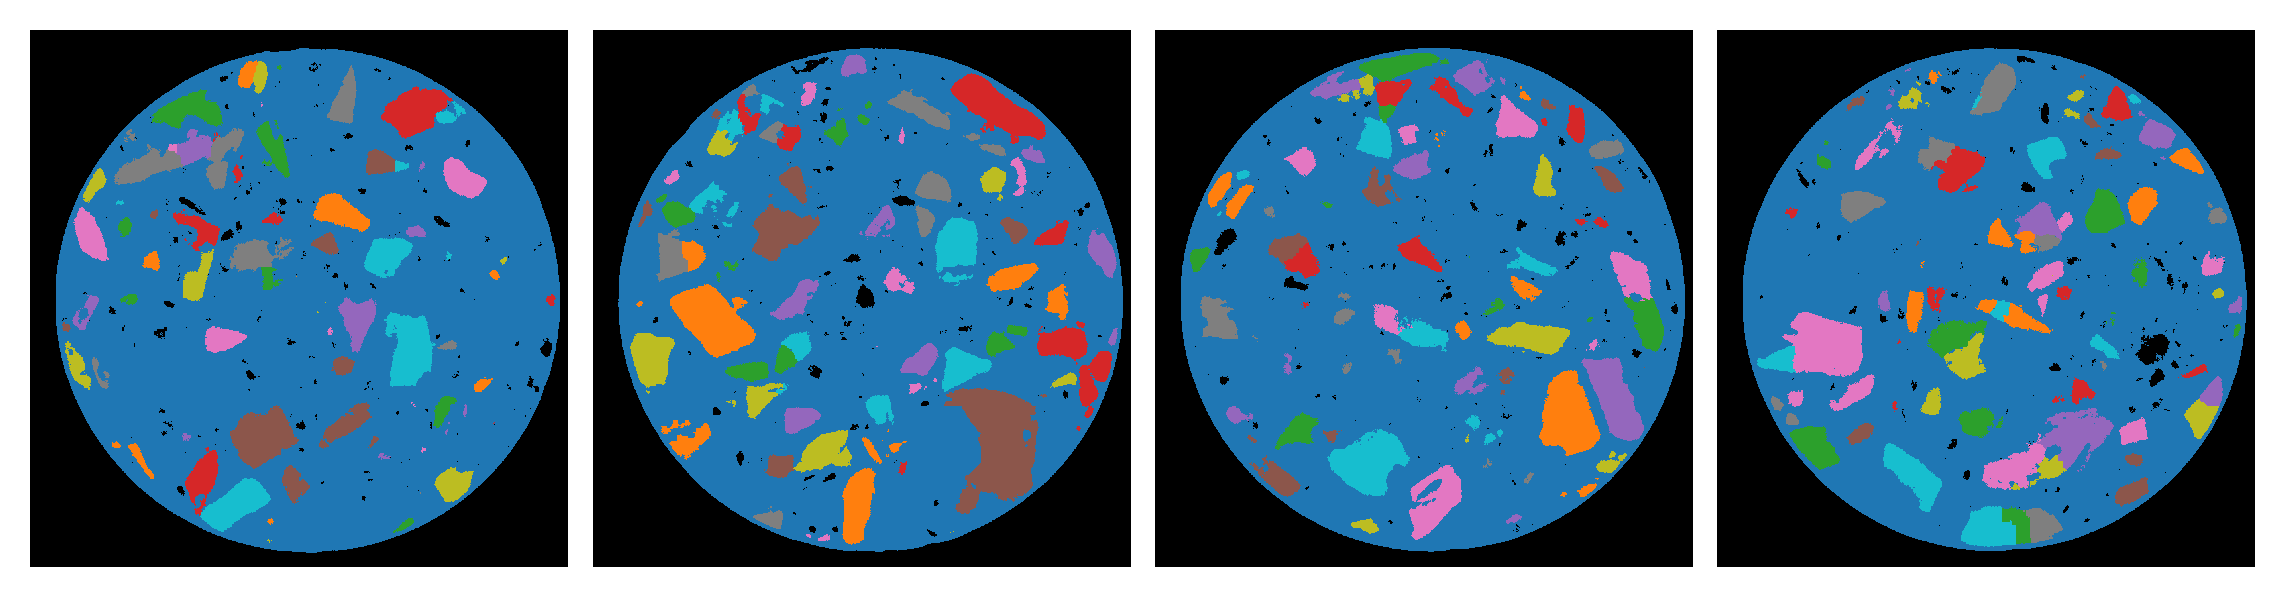

In [8]:
# Merge semantic and instance segmentation to represent binder and grains
imgs_labeled = segment.merge_segmentations(imgs_semantic, imgs_instance)
# Visualize instance segmented grains with binder
fig, axes = view.plot_color_labels(
    imgs_labeled,
    nslices=ui['nslices'],
    fig_w=7.5,
    dpi=300
)